In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
p_nw = []
p_net_nw = []
loss_nw = []
loss_net_nw = []
bool_nw = []

for network_name in ["Random_ER", "Random_SF", "ChIP_hTFtarget", "ChIP_TIP", "ChIP_TIP_GM12878", "CoExpr_GTEx_EBV_0.75", "CoExpr_ENCODE_GM12878_0.75", "BIOGRID", "STRING", "Combine", "DAGMA_threshold0.3"]:
    
    # measurements across 10 random sample split
    p_rs = []
    p_net_rs = []
    loss_rs = []
    loss_net_rs = []
    bool_rs = []
    
    for rs in range(10):
        # read data
        X_train = pd.read_csv("../../result/input_GTEx_phyloP/%d/X_train_stratified" % rs, sep="\t", index_col=0).values
        X_valid = pd.read_csv("../../result/input_GTEx_phyloP/%d/X_valid_stratified" % rs, sep="\t", index_col=0).values
        X_test = pd.read_csv("../../result/input_GTEx_phyloP/%d/X_test_stratified" % rs, sep="\t", index_col=0).values
        Y_test = pd.read_csv("../../result/input_GTEx_phyloP/%d/Y_test_stratified" % rs, sep="\t", index_col=0).values.reshape(-1)
        Y_test_gene = pd.read_csv("../../result/input_GTEx_phyloP/%d/Y_test_stratified" % rs, sep="\t", index_col=0).index

        test_mask = np.concatenate([[False] * len(X_train), [False] * len(X_valid), [True] * len(X_test)])

        # mask of whether a test node is in the DAGMA graph
        dag = pd.read_csv("../../result/network_GTEx_phastcons/DAGMA_thresholdAdaptive.tsv", sep="\t", header=None)
        id2genes = pd.read_csv("../../result/network_GTEx_phastcons/valid_genes", sep="\t").set_index("ID")['genes'].to_dict()
        dag[0] = dag[0].map(id2genes)
        dag[1] = dag[1].map(id2genes)
        dag_genes = list(set.union(set(dag[0]), set(dag[1])))
        test_inDAG = Y_test_gene.isin(dag_genes)

        # measurements across 10 random init repeats
        p_rep = []
        p_net_rep = []
        loss_rep = []
        loss_net_rep = []

        for rep in range(10):
            prefix = "../../result/model_GTEx_phyloP/%s/%d/model%d" % (network_name, rs, rep)
            with open(prefix+".para", "rb") as f:
                best_params, X1, out, loss1, loss2 = pickle.load(f)
            Y_pred = out[test_mask].reshape(-1)

            loss_rep.append(F.mse_loss(torch.tensor(Y_test), torch.tensor(Y_pred)).item())
            loss_net_rep.append(F.mse_loss(torch.tensor(Y_test[test_inDAG]), torch.tensor(Y_pred[test_inDAG])).item())
            p_rep.append(pearsonr(Y_test, Y_pred)[0])
            p_net_rep.append(pearsonr(Y_test[test_inDAG], Y_pred[test_inDAG])[0])
        bool_rep = ~np.isnan(np.array(p_net_rep))

        p_rs.append(p_rep)
        p_net_rs.append(p_net_rep)
        loss_rs.append(loss_rep)
        loss_net_rs.append(loss_net_rep)
        bool_rs.append(bool_rep)
        
    p_nw.append(p_rs)
    p_net_nw.append(p_net_rs)
    loss_nw.append(loss_rs)
    loss_net_nw.append(loss_net_rs)
    bool_nw.append(bool_rs)

/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/gpfs/slayman/pi/gerstein/jg2447/conda_envs/DAG/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [3]:
p_nw = np.array(p_nw)
p_net_nw = np.array(p_net_nw)
loss_nw = np.array(loss_nw)
loss_net_nw = np.array(loss_net_nw)
bool_nw = np.array(bool_nw)

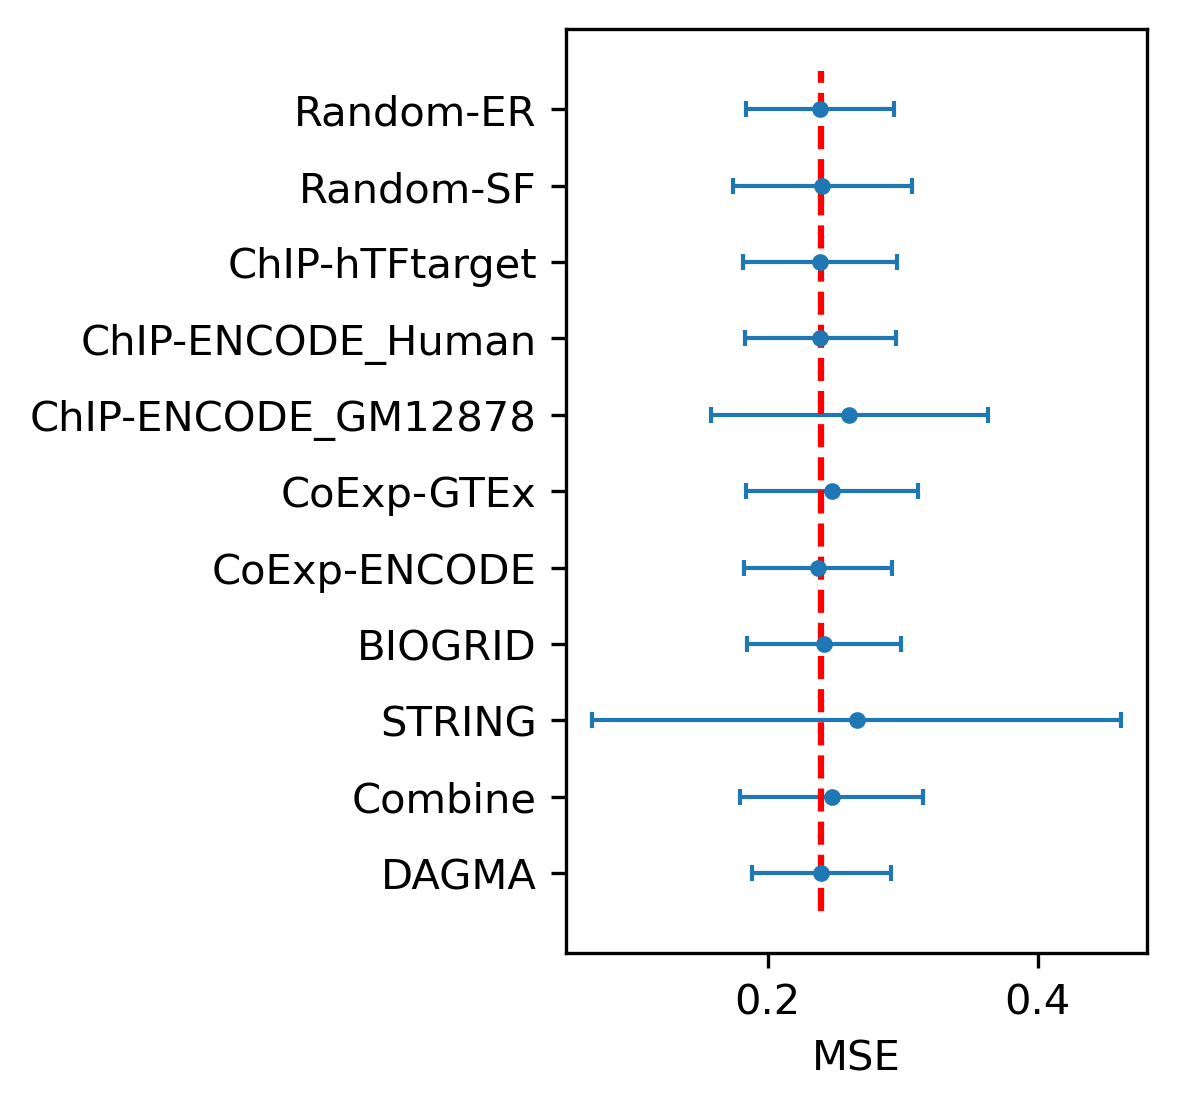

In [4]:
mean_mse = []
std_mse = []
for ii in range(11):
    mean_mse.append(loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].mean())
    std_mse.append(loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].std())

plt.figure(dpi=300, figsize=(2.5, 4))
(_, caps, _) = plt.errorbar(mean_mse[::-1], range(len(mean_mse)), xerr=std_mse[::-1], fmt='.', elinewidth=1, capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

ax = plt.gca()
ax.yaxis.set_ticks(range(len(mean_mse)))
ax.yaxis.set_ticklabels(["Random-ER", "Random-SF", "ChIP-hTFtarget", "ChIP-ENCODE_Human", "ChIP-ENCODE_GM12878", "CoExp-GTEx", "CoExp-ENCODE", "BIOGRID", "STRING", "Combine", "DAGMA"][::-1])
ax.set_xlabel("MSE")

ax.vlines(mean_mse[-1], -0.5, len(mean_mse)-0.5, color='red', linestyles='dashed')
plt.savefig("./gtex_phylop_mse.pdf", dpi="figure", bbox_inches="tight")

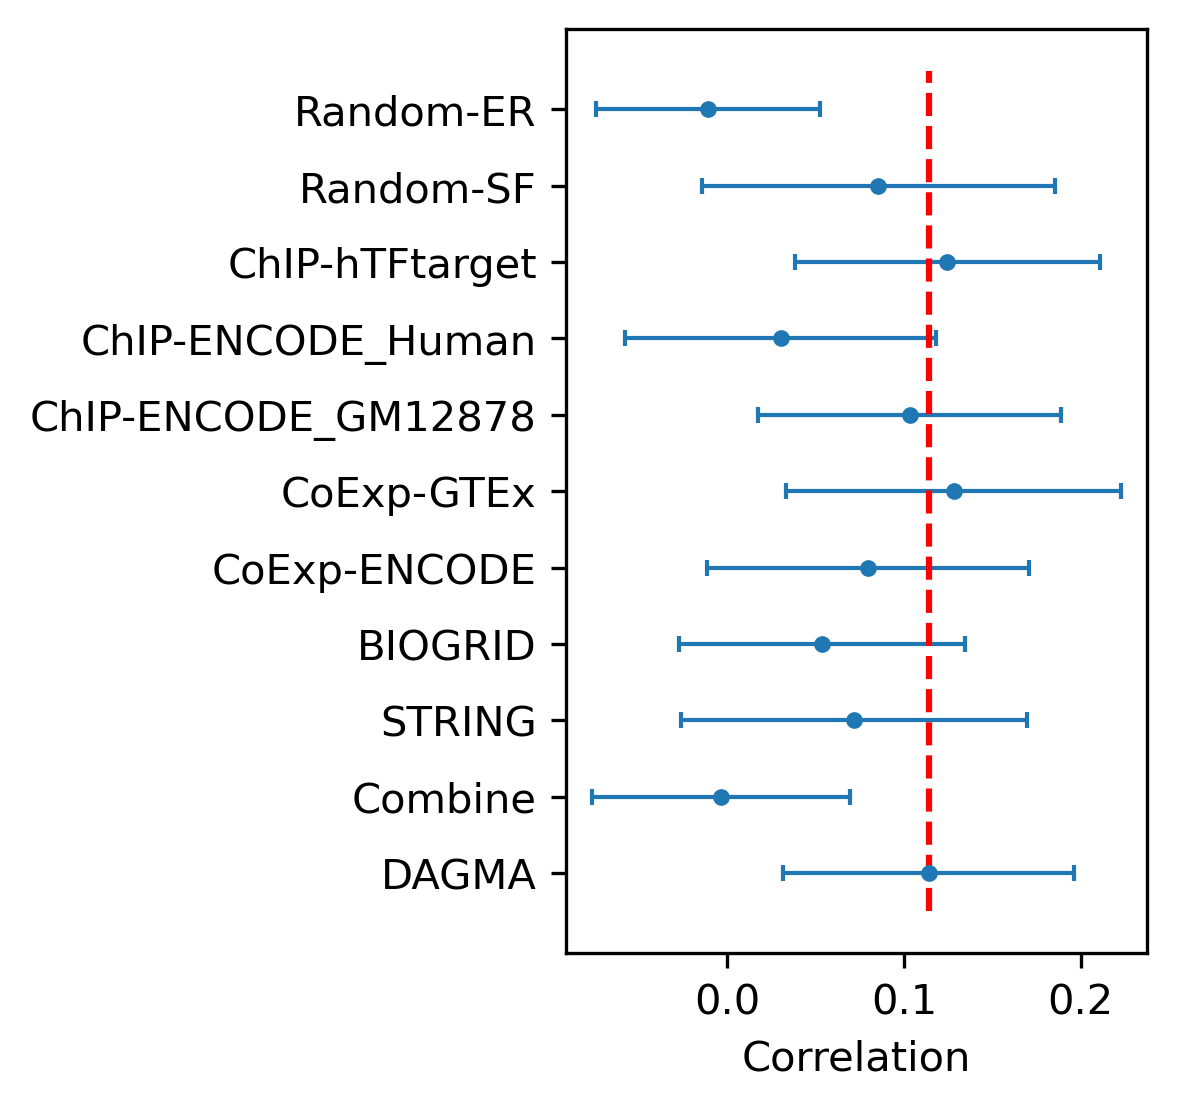

In [5]:
mean_mse = []
std_mse = []
for ii in range(11):
    mean_mse.append(p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].mean())
    std_mse.append(p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)].std())

plt.figure(dpi=300, figsize=(2.5, 4))
(_, caps, _) = plt.errorbar(mean_mse[::-1], range(len(mean_mse)), xerr=std_mse[::-1], fmt='.', elinewidth=1, capsize=2)

for cap in caps:
    cap.set_markeredgewidth(1)

ax = plt.gca()
ax.yaxis.set_ticks(range(len(mean_mse)))
ax.yaxis.set_ticklabels(["Random-ER", "Random-SF", "ChIP-hTFtarget", "ChIP-ENCODE_Human", "ChIP-ENCODE_GM12878", "CoExp-GTEx", "CoExp-ENCODE", "BIOGRID", "STRING", "Combine", "DAGMA"][::-1])
ax.set_xlabel("Correlation")

ax.vlines(mean_mse[-1], -0.5, len(mean_mse)-0.5, color='red', linestyles='dashed')
plt.savefig("./gtex_phylop_p.pdf", dpi="figure", bbox_inches="tight")

In [6]:
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind_from_stats

In [7]:
for ii in range(11):
    a1 = loss_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = loss_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=-0.10374696758333701, pvalue=0.9174787607491546)
Ttest_indResult(statistic=0.09002843184533975, pvalue=0.928362803203368)
Ttest_indResult(statistic=-0.12924197371856655, pvalue=0.8973021740582963)
Ttest_indResult(statistic=-0.11190007581736199, pvalue=0.9110213314723875)
Ttest_indResult(statistic=1.7885152973784795, pvalue=0.07575965304264687)
Ttest_indResult(statistic=0.9692297236784413, pvalue=0.33367652327094777)
Ttest_indResult(statistic=-0.3453391998562585, pvalue=0.7302159362744692)
Ttest_indResult(statistic=0.24868824519231097, pvalue=0.8038685724776957)
Ttest_indResult(statistic=1.2717908838696261, pvalue=0.2060919130889545)
Ttest_indResult(statistic=0.8790711299326551, pvalue=0.3805916416334103)
Ttest_indResult(statistic=0.0, pvalue=1.0)


In [8]:
for ii in range(11):
    a1 = p_nw[ii,:,:].reshape(-1)[bool_nw[ii,:,:].reshape(-1)]
    a2 = p_nw[-1,:,:].reshape(-1)[bool_nw[-1,:,:].reshape(-1)]
    print(ttest_ind(a1, a2, equal_var=False))

Ttest_indResult(statistic=-11.821099041489163, pvalue=2.4171193954837158e-24)
Ttest_indResult(statistic=-2.1710489861756455, pvalue=0.031184829618713293)
Ttest_indResult(statistic=0.8697988126955123, pvalue=0.38548971465906545)
Ttest_indResult(statistic=-6.813937858245066, pvalue=1.2229936218534381e-10)
Ttest_indResult(statistic=-0.9124608735002216, pvalue=0.362642333939897)
Ttest_indResult(statistic=1.1007530828344496, pvalue=0.27237974016948985)
Ttest_indResult(statistic=-2.7490131486033853, pvalue=0.006550304567930153)
Ttest_indResult(statistic=-5.168166227679095, pvalue=5.851550012356301e-07)
Ttest_indResult(statistic=-3.2650164876595182, pvalue=0.0012978907456471175)
Ttest_indResult(statistic=-10.438878774281456, pvalue=1.9394709049089094e-20)
Ttest_indResult(statistic=0.0, pvalue=1.0)
